If you run on Google Colab, run the code below to download the dataset

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'train', 'test', 'train.csv']


Import libraries

In [2]:
import sys

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import optim

import torchvision.transforms as transforms
import torchvision

from fastprogress import master_bar, progress_bar

from PIL import Image

# Read dataset

In [3]:
data = pd.read_csv("../input/train.csv")
data.head()

,filename,opacity,diabetic retinopathy,glaucoma,macular edema,macular degeneration,retinal vascular occlusion,normal
0,c24a1b14d253.jpg,0,0,0,0,0,1,0
1,9ee905a41651.jpg,0,0,0,0,0,1,0
2,3f58d128caf6.jpg,0,0,1,0,0,0,0
3,4ce6599e7b20.jpg,1,0,0,0,1,0,0
4,0def470360e4.jpg,1,0,0,0,1,0,0


# Data analyzing

## Analyze distribution of 0 and 1 for each label

In [4]:
for label in data.columns[1:]:
    print("Distribution of", label)
    print(data[label].value_counts())

Distribution of opacity
0    1902
1    1533
Name: opacity, dtype: int64
Distribution of diabetic retinopathy
0    2680
1     755
Name: diabetic retinopathy, dtype: int64
Distribution of glaucoma
0    2838
1     597
Name: glaucoma, dtype: int64
Distribution of macular edema
0    2919
1     516
Name: macular edema, dtype: int64
Distribution of macular degeneration
0    2861
1     574
Name: macular degeneration, dtype: int64
Distribution of retinal vascular occlusion
0    2995
1     440
Name: retinal vascular occlusion, dtype: int64
Distribution of normal
0    2910
1     525
Name: normal, dtype: int64


As can be observed, the number of label 0 is much more larger than label 1

## Analyze combination of classes

In [5]:
LABELS = data.columns[1:]
def build_label(row):
    return ",".join([LABELS[idx] for idx, val in enumerate(row[1:]) if val == 1])
        
data.apply(lambda x: build_label(x), axis=1).value_counts()

opacity                                                                  671
normal                                                                   525
glaucoma                                                                 327
macular degeneration                                                     299
opacity,macular degeneration                                             212
diabetic retinopathy                                                     212
opacity,diabetic retinopathy                                             186
retinal vascular occlusion                                               170
diabetic retinopathy,macular edema                                       162
opacity,diabetic retinopathy,macular edema                               154
opacity,glaucoma                                                         140
macular edema,retinal vascular occlusion                                  74
opacity,macular edema,retinal vascular occlusion                          62

In [6]:
LABELS

Index(['opacity', 'diabetic retinopathy', 'glaucoma', 'macular edema',
       'macular degeneration', 'retinal vascular occlusion', 'normal'],
      dtype='object')

As we can see, **opacity**, **normal** and **glaucoma** are diseases that share largest proportions in label distribution. The other diseases or combinations just account for small pieces.

# Observations on the dataset
The dataset provided is extremely imbalanced. In this baseline model, by simply train the model the original dataset, we will easily get overfitting on the training set and the score on the test set is very low. With the proposed methods below, you will tweak the training process and improve the metric score on the test set:
- **Image Augmentation**: By augmenting images, we will have more data and make the training set become more regularize. [imgaug](https://github.com/aleju/imgaug) is a very strong augmentation library that you can use in this assignment
- **Data sampling**: the idea here is to make the distribution between classes in the dataset balance. There are 2 kinds: oversampling and undersampling
- **Adjust loss function**: the current loss function becomes very small after several epochs. By adding weights, we adjust the loss function to make it suitable for this imbalanced dataset. You can check the [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss) and try applying it.

# Split the dataset

For the data provided, we will split the dataset to 80% for training and 20% for validation

In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=2019)

**To simplify the baseline model, the dataset is splited randomly. However, to improve the model, cross-validation techniques can be applied here**

# Build and train baseline model

In this notebook, we will use Pytorch library to implement and train ResNet50 as a baseline model. With initial weights from ImageNet, we will retrain all layers for this problem.

In [8]:
IMAGE_SIZE = 224                              # Image size (224x224)
IMAGENET_MEAN = [0.485, 0.456, 0.406]         # Mean of ImageNet dataset (used for normalization)
IMAGENET_STD = [0.229, 0.224, 0.225]          # Std of ImageNet dataset (used for normalization)
BATCH_SIZE = 20                           
LEARNING_RATE = 0.001
LEARNING_RATE_SCHEDULE_FACTOR = 0.1           # Parameter used for reducing learning rate
LEARNING_RATE_SCHEDULE_PATIENCE = 5           # Parameter used for reducing learning rate
MAX_EPOCHS = 100                              # Maximum number of training epochs

## Implement Dataset loader
In Pytorch, you need to subclass the `Dataset` of Pytorch to custom the data loading process. The **Image Augmentation** would be executed in this subclass

In [9]:
class FundusDataset(Dataset):
    
    def __init__(self, folder_dir, dataframe, image_size, normalization):
        """
        Init Dataset
        
        Parameters
        ----------
        folder_dir: str
            folder contains all images
        dataframe: pandas.DataFrame
            dataframe contains all information of images
        image_size: int
            image size to rescale
        normalization: bool
            whether applying normalization with mean and std from ImageNet or not
        """
        self.image_paths = [] # List of image paths
        self.image_labels = [] # List of image labels
        
        # Define list of image transformations
        image_transformation = [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ]
        
        if normalization:
            # Normalization with mean and std from ImageNet
            image_transformation.append(transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD))
        
        self.image_transformation = transforms.Compose(image_transformation)
        
        # Get all image paths and image labels from dataframe
        for index, row in dataframe.iterrows():
            image_path = os.path.join(folder_dir, row.filename)
            self.image_paths.append(image_path)
            self.image_labels.append(row[1:])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        """
        Read image at index and convert to torch Tensor
        """
        
        # Read image
        image_path = self.image_paths[index]
        image_data = Image.open(image_path).convert("RGB") # Convert image to RGB channels
        
        # TODO: Image augmentation code would be placed here
        
        # Resize and convert image to torch tensor 
        image_data = self.image_transformation(image_data)
        
        return image_data, torch.FloatTensor(self.image_labels[index])

Create training dataset

In [10]:
train_dataset = FundusDataset("../input/train/train", train_data, IMAGE_SIZE, True)

Besides, `DataLoader` also need to be created. For the training data loader, we need to shuffle the dataset.

In [11]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

Let's check the size of data and label for each iteration

In [12]:
for data, label in train_dataloader:
    print(data.size())
    print(label.size())
    break

torch.Size([20, 3, 224, 224])
torch.Size([20, 7])


We also need to create validation dataloader. Different from training dataloader, we don't shuffle the validation set

In [13]:
val_dataset = FundusDataset("../input/train/train", val_data, IMAGE_SIZE, True)
val_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

## Define model
In the baseline, we use ResNet50 pretrained on ImageNet dataset. The classifier of model would be replaced with a new dense layer to make the output suit the problem.

In [14]:
class ResNet50(nn.Module):
    def __init__(self, num_classes, is_trained=True):
        """
        Init model architecture
        
        Parameters
        ----------
        num_classes: int
            number of classes
        is_trained: bool
            whether using pretrained model from ImageNet or not
        """
        super().__init__()
        
        # Load the resnet50 from ImageNet
        self.net = torchvision.models.resnet50(pretrained=is_trained)
        
        # freeze 
        for param in model.parameters():
            param.require_grad = False
        
        # Get the input dimension of last layer
        kernel_count = self.net.fc.in_features
        
        # Replace last layer with new layer that have num_classes nodes, after that apply Sigmoid to the output
        self.net.fc = nn.Sequential(nn.Linear(kernel_count, num_classes), nn.Sigmoid())
        
    def forward(self, inputs):
        """
        Forward the netword with the inputs
        """
        return self.net(inputs)

In [15]:
class DenseNet121(nn.Module):
    def __init__(self, num_classes, is_trained=True):
        """
        Init model architecture
        
        Parameters
        ----------
        num_classes: int
            number of classes
        is_trained: bool
            whether using pretrained model from ImageNet or not
        """
        super().__init__()
        
        # Load the resnet50 from ImageNet
        self.net = torchvision.models.densenet121(pretrained=is_trained)
        
        # freeze 
        for param in self.net.parameters():
            param.require_grad = False
        
        # Get the input dimension of last layer
        kernel_count = self.net.classifier.in_features
        
        # Replace last layer with new layer that have num_classes nodes, after that apply Sigmoid to the output
        self.net.classifier = nn.Sequential(nn.Linear(kernel_count, num_classes), nn.Sigmoid())
        
    def forward(self, inputs):
        """
        Forward the netword with the inputs
        """
        return self.net(inputs)

## Check GPU available

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Create model and get number of trainable parameters

Create model and check model architecture

In [17]:
model = DenseNet121(num_classes=len(LABELS)).to(device)
model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /tmp/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:00<00:00, 80114583.34it/s]


DenseNet121(
  (net): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, 

Number of trainable parameters

In [18]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

6961031

We need to train about 23 millions parameters

## Define loss function, optimizer, and learning rate scheduler

In [19]:
# Loss function
loss_criteria = nn.BCELoss()

# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5)

# Learning rate will be reduced automatically during training
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = LEARNING_RATE_SCHEDULE_FACTOR, patience = LEARNING_RATE_SCHEDULE_PATIENCE, mode = 'max', verbose=True)

## Compute F1-score 
Because we have multi labels, we need to calculate F1-score for each class.

In [20]:
def multi_label_f1(y_gt, y_pred):
    """ Calculate F1 for each class

    Parameters
    ----------
    y_gt: torch.Tensor
        groundtruth
    y_pred: torch.Tensor
        prediction

    Returns
    -------
    list
        F1 of each class
    """
    f1_out = []
    gt_np = y_gt.to("cpu").numpy()
    pred_np = (y_pred.to("cpu").numpy() > 0.5) * 1.0
    assert gt_np.shape == pred_np.shape, "y_gt and y_pred should have the same size"
    for i in range(gt_np.shape[1]):
        f1_out.append(f1_score(gt_np[:, i], pred_np[:, i]))
    return f1_out

## Training each epoch
This function will be called to train on one epoch


In [21]:
def epoch_training(epoch, model, train_dataloader, device, loss_criteria, optimizer, mb):
    """
    Epoch training

    Paramteters
    -----------
    epoch: int
      epoch number
    model: torch Module
      model to train
    train_dataloader: Dataset
      data loader for training
    device: str
      "cpu" or "cuda"
    loss_criteria: loss function
      loss function used for training
    optimizer: torch optimizer
      optimizer used for training
    mb: master bar of fastprogress
      progress to log

    Returns
    -------
    float
      training loss
    """
    # Switch model to training mode
    model.train()
    training_loss = 0 # Storing sum of training losses
   
    # For each batch
    for batch, (images, labels) in enumerate(progress_bar(train_dataloader, parent=mb)):
        
        # Move X, Y  to device (GPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear previous gradient
        optimizer.zero_grad()

        # Feed forward the model
        pred = model(images)
        loss = loss_criteria(pred, labels)

        # Back propagation
        loss.backward()

        # Update parameters
        optimizer.step()

        # Update training loss after each batch
        training_loss += loss.item()

        mb.child.comment = f'Training loss {training_loss/(batch+1)}'

    del images, labels, loss
    if torch.cuda.is_available(): torch.cuda.empty_cache()

    # return training loss
    return training_loss/len(train_dataloader)

## Evaluate model
This function is used to validate the model on the validation dataset

In [22]:
def evaluating(epoch, model, val_loader, device, loss_criteria, mb):
    """
    Validate model on validation dataset
    
    Parameters
    ----------
    epoch: int
        epoch number
    model: torch Module
        model used for validation
    val_loader: Dataset
        data loader of validation set
    device: str
        "cuda" or "cpu"
    loss_criteria: loss function
      loss function used for training
    mb: master bar of fastprogress
      progress to log
  
    Returns
    -------
    float
        loss on validation set
    float
        metric score on validation set
    """

    # Switch model to evaluation mode
    model.eval()

    val_loss = 0                                   # Total loss of model on validation set
    out_pred = torch.FloatTensor().to(device)      # Tensor stores prediction values
    out_gt = torch.FloatTensor().to(device)        # Tensor stores groundtruth values

    with torch.no_grad(): # Turn off gradient
        # For each batch
        for step, (images, labels) in enumerate(progress_bar(val_loader, parent=mb)):
            # Move images, labels to device (GPU)
            images = images.to(device)
            labels = labels.to(device)

            # Update groundtruth values
            out_gt = torch.cat((out_gt,  labels), 0)

            # Feed forward the model
            ps = model(images)
            loss = loss_criteria(ps, labels)

            # Update prediction values
            out_pred = torch.cat((out_pred, ps), 0)

            # Update validation loss after each batch
            val_loss += loss
            mb.child.comment = f'Validation loss {val_loss/(step+1)}'

    # Clear memory
    del images, labels, loss
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    # return validation loss, and metric score
    return val_loss/len(val_loader), np.array(multi_label_f1(out_gt, out_pred)).mean()

## Fully training
Fully training the model 

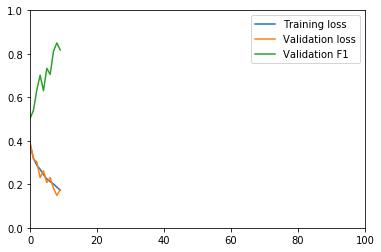

In [23]:
# Best F1 value during training
best_score = 0
model_path = "resnet50.pth"
training_losses = []
validation_losses = []
validation_score = []


# Config progress bar
mb = master_bar(range(MAX_EPOCHS))
mb.names = ['Training loss', 'Validation loss', 'Validation F1']
x = []

# Training each epoch
for epoch in mb:
    mb.first_bar.comment = f'Best F1 score: {best_score}'
    x.append(epoch)

    # Training
    train_loss = epoch_training(epoch, model, train_dataloader, device, loss_criteria, optimizer, mb)
    mb.write('Finish training epoch {} with loss {:.4f}'.format(epoch, train_loss))
    training_losses.append(train_loss)

    # Evaluating
    val_loss, new_score = evaluating(epoch, model, val_dataloader, device, loss_criteria, mb)
    mb.write('Finish validation epoch {} with loss {:.4f} and score {:.4f}'.format(epoch, val_loss, new_score))
    validation_losses.append(val_loss)
    validation_score.append(new_score)

    # Update learning rate
    lr_scheduler.step(new_score)

    # Update training chart
    mb.update_graph([[x, training_losses], [x, validation_losses], [x, validation_score]], [0,MAX_EPOCHS], [0,1])

    # Save model
    if best_score < new_score:
        mb.write(f"Improve F1 from {best_score} to {new_score}")
        best_score = new_score

        # Saving model: https://pytorch.org/tutorials/beginner/saving_loading_models.html
        torch.save(model.state_dict(), model_path)

# Inference

Read the test data

In [24]:
test_df = pd.read_csv("../input/sample_submission.csv")
test_df.head()

,filename,predicted
0,e742d34a26d4.jpg,0 0
1,b193b6a6d68d.jpg,0 0
2,07e4191fa3a8.jpg,0 0
3,b1a911cb2e6c.jpg,0 0
4,d8ab9cda1b33.jpg,0 0


Predict function

In [25]:
# Define list of image transformations
image_transformation = [
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
]
# Normalization with mean and std from ImageNet
image_transformation.append(transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD))
image_transformation = transforms.Compose(image_transformation)

def predict(image_path, model, device):
    """ Predict image
    
    Parameters
    ----------
    image_path: str
        image path to predict
    model: nn.Module
        model used to predict
    device: str
        'cpu' or 'cuda'
        
    Returns
    -------
    str
        list of label indices
    """
    global image_transformation
    
    # Read image
    image_data = Image.open(image_path).convert('RGB')
    image_data = image_transformation(image_data)
    
    predicted_label = []
    with torch.no_grad():
        ps = model(image_data.unsqueeze(0).to(device))
        ps = ps[0]
        for i in range(ps.size()[0]):
            if ps[i].item() > 0.5: # Threshold is 0.5
                predicted_label.append(i)
    return " ".join([str(label) for label in predicted_label])

Load best model weights and switch to evaludation mode

In [26]:
model.load_state_dict(torch.load(model_path))
model.eval()

DenseNet121(
  (net): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, 

Predict test images

In [27]:
test_df['predicted'] = test_df.filename.map(lambda x: predict(os.path.join("../input/test/test",x), model, device))

Write result to submission file

In [28]:
test_df.to_csv("submission.csv", index=False)

- Train with DenseNet 121, Adam, BCELoss. Error = ? Start: 0h25'
- Train with 

In [29]:
!ls


__notebook__.ipynb  __output__.json  resnet50.pth  submission.csv
